In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from io import BytesIO
from PIL import Image

def visualize_voxel(voxel_grid):
    """
    Visualizes a 3D binary voxel grid using matplotlib.

    Parameters:
    voxel_grid (numpy.ndarray): A 3D binary voxel grid where 1 indicates occupancy and 0 indicates empty.
    """

    # Get the coordinates of occupied voxels
    occupied_voxels = np.argwhere(voxel_grid == 1)

    # Create a 3D plot
    fig = plt.figure()
    plt.tight_layout()

    ax = fig.add_subplot(111, projection='3d')

    # Plot occupied voxels as scatter points
    ax.scatter(occupied_voxels[:, 0], occupied_voxels[:, 2], occupied_voxels[:, 1])

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set the aspect ratio to be equal
    ax.set_box_aspect([1, 1, 1])

    # Set the limits for the axes
    ax.set_xlim([0, voxel_grid.shape[0]])
    ax.set_ylim([0, voxel_grid.shape[1]])
    ax.set_zlim([0, voxel_grid.shape[2]])
    
    ax.axis("off")
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)  # Move the buffer cursor to the beginning
    plt.close()
    # Convert the buffer into a Pillow Image
    img = Image.open(buf)
    return img

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def visualize_point(points):
    x = points[:, 0]
    y = points[:, 2]
    z = points[:, 1]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])
    
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)  # Move the buffer cursor to the beginning
    plt.close()
    # Convert the buffer into a Pillow Image
    img = Image.open(buf)
    return img

In [15]:
# load the preprocessed voxel data.
voxels = np.load("./data/hdf5_data/chair_voxels_train.npy")
print(voxels.shape)

(2658, 128, 128, 128)


In [16]:
from tqdm import tqdm

target_points_raw_list = []

for i in tqdm(range(voxels.shape[0])):
    target_points_raw = np.argwhere(voxels[i]==1).astype(np.float64)
    target_points_raw_list.append(target_points_raw)

result = np.vstack(target_points_raw_list)

100%|██████████| 2658/2658 [00:16<00:00, 161.98it/s]


In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
result = scaler.fit_transform(result)

In [18]:
target_points_list = []

for i in range(len(target_points_raw_list)):
    target_points_list.append(scaler.transform(target_points_raw_list[i]))

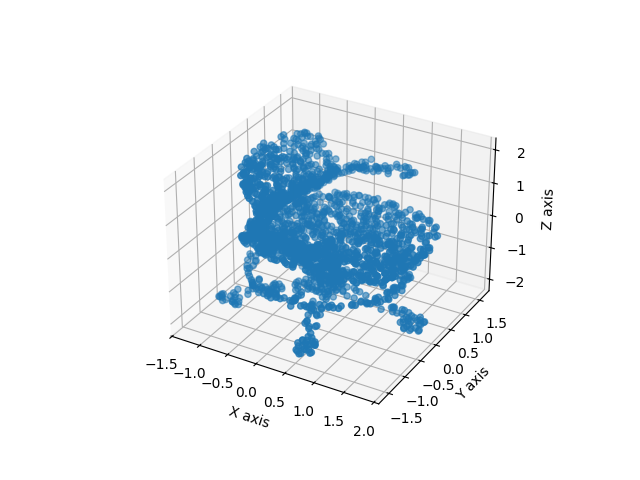

In [19]:
visualize_point(target_points_list[0])

In [36]:
from network import SimpleNet
from ddpm import BaseScheduler, DiffusionModule

# hyperparameters #
# Don't change it
device = "cuda:0"
config = {
    "num_diffusion_steps": 1000,
    "dim_hids": [128, 128, 128],
    "lr": 1e-3,
    "batch_size": 1,
    "train_num_steps": 100000,
    "device": device,
}

###################

def build_ddpm(config):
    network = SimpleNet(dim_in=3, 
                        dim_out=3, 
                        dim_hids=config["dim_hids"], 
                        num_timesteps=config["num_diffusion_steps"]
                       )
    var_scheduler = BaseScheduler(config["num_diffusion_steps"])

    ddpm = DiffusionModule(network, var_scheduler).to(config["device"])
    return ddpm

ddpm = build_ddpm(config)

In [21]:
def get_data_iterator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [25]:
def pad_collate_fn(batch):
    max_len = max(points.shape[0] for points in batch)
    padded_batch = []

    for points in batch:
        pad_size = max_len - points.shape[0]
        padded_points = torch.nn.functional.pad(torch.tensor(points), (0, 0, 0, pad_size))
        padded_batch.append(padded_points)

    return torch.stack(padded_batch)

In [26]:
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(ddpm.parameters(), lr=config["lr"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Initialize DataLoaders
train_dl = DataLoader(target_points_list, batch_size=16, collate_fn=pad_collate_fn)
train_it = iter(train_dl)

/root/miniconda3/envs/project/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [45]:
train_num_steps = 50000
log_interval = 2000
save_dir = "./result"
num_vis_particles = 2000

step = 0
losses = []
val_losses = []  # To store validation losses

with tqdm(initial=step, total=train_num_steps) as pbar:
    while step < train_num_steps:
        if step % log_interval == 0 and step != 0:
            # Evaluation and Logging
            ddpm.eval()
            
            # Plot and save training loss
            plt.plot(losses)
            plt.savefig(f"{save_dir}/loss.png")
            plt.close()
            
            # Generate and save samples
            samples = ddpm.p_sample_loop(shape=(num_vis_particles, 3))
            image = visualize_point(samples.cpu().numpy())
            image.save(f"{save_dir}/step={step}.png")

            # Save model checkpoint
            ddpm.save(f"{save_dir}/last.ckpt")
            
            ddpm.train()

        try:
            batch = next(train_it).float().to(device)
        except StopIteration:
            train_it = iter(train_dl)
            batch = next(train_it).float().to(device)
        
        loss = ddpm.compute_loss(batch)
        pbar.set_description(f"Loss: {loss.item():.4f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        step += 1
        pbar.update(1)

Loss: 1.0024:  24%|██▍       | 12000/50000 [01:29<04:43, 133.83it/s]


KeyboardInterrupt: 